# Cross-modal retrieval in Canonical Correlation Analysis latent space of spectral and structural embeddings
The spectral and molecular embeddings are combined into one embedding by utilising Canonical Correlation Analysis (CCA).

1. Create embeddings
- [Spec2Vec](https://github.com/iomega/spec2vec) and [MS2DeepScore](https://github.com/matchms/ms2deepscore) learn relationships between peaks as they create spectral embeddings. Within these embeddings, similar spectra are placed nearby each other in the latent space. This is also true for molecular embeddings, for example ones made with [Mol2Vec](https://github.com/samoturk/mol2vec).

2. Canonical Correlation Analysis (CCA)
- **CCA** maximizes correlation between two given data views by reducing the dimensions and morphing the data in a way so that the two data views are similar to each other. Here, the spectral embeddings are considered the X and the structural embeddings the Y. Every X (spectrum) has a corresponding Y (structure). 

3. Cross-modal retrieval
- Lastly, the new combined latent space is assessed. For every query X, the latent space is searched for *n* amount of nearest target Y points using cosine or euclidean distance. These *n* amount of matches are then compared to the 'real' Y that corresponds to the query X by calculating the **tanimoto similarity** between the two respective structures. Out of all the tanimoto scores, the max one is taken and then used to make a distribution plot. And this is done for different amounts of nearest neighbours. Additionally, a random distribution is also plotted to show if the real distribution is better or worse than random.

In [1]:
!pwd
!python --version

/lustre/BIF/nobackup/unen004/thesis/cca
Python 3.8.12


## 1. Create embeddings
### Load in spectral data
GNPS 21-04-09 all positive

In [1]:
import os 
import pickle
import pandas as pd

path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings"
dataset = "ALL_GNPS_210409_positive"

# load spectra annotated with molecular structures
spectra_fn = os.path.join(path, "datasets", dataset,
                          "ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_only_annotated.pickle")
with open(spectra_fn, "rb") as f:
    all_spectrums = pickle.load(f)
    
print(len(all_spectrums))

187152


In [2]:
# Load in class info to merge into df later 
class_fn = os.path.join(path, "classifications", dataset,
                       "ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_only_annotated_classes.txt")
classes = pd.read_table(class_fn, sep = "\t") #, on_bad_lines="skip"

In [3]:
# Load in tanimoto similarity matrix for comparisons later
tanimoto_fn = os.path.join(path, "datasets", dataset, 
                           "ALL_GNPS_210409_positive_tanimoto_scores.pickle")
with open(tanimoto_fn, "rb") as f:
    tanimoto_matrix = pickle.load(f)

### Filter on unique inchikey
Function obtained from Joris

In [4]:
from collections import OrderedDict
import numpy as np

def count_higher_peaks(spectrum, threshold = 0.1):
    return np.sum(spectrum.peaks.intensities/spectrum.peaks.intensities.max() >= threshold)

def get_ids_for_unique_inchikeys(spectrums): #: List[SpectrumType]
    """Return indices for best chosen spectra for each unique inchikey
    Parameters
    ----------
    spectrums:
        Input spectra
    """
    # collect all inchikeys (first 14 characters)
    inchikey_collection = OrderedDict()
    for i, spec in enumerate(spectrums):
        inchikey = spec.get("inchikey")
        if inchikey:
            if inchikey[:14] in inchikey_collection:
                inchikey_collection[inchikey[:14]] += [i]
            else:
                inchikey_collection[inchikey[:14]] = [i]

    intensity_thres = 0.01
    n_peaks_required = 10
    ID_picks = []

    inchikey14_unique = [x for x in inchikey_collection.keys()]

    # Loop through all unique inchiques (14 first characters)
    for inchikey14 in inchikey14_unique:
        specIDs = np.array(inchikey_collection[inchikey14])
        if specIDs.size == 1:
            ID_picks.append(specIDs[0])
        else:
            # 1 select spec with sufficient peaks (e.g. 10 with intensity 0.01)
            num_peaks = np.array([count_higher_peaks(
                spectrums[specID], intensity_thres) for
                                  specID in specIDs])
            sufficient_peaks = np.where(num_peaks >= n_peaks_required)[0]
            if sufficient_peaks.size == 0:
                sufficient_peaks = np.where(num_peaks == max(num_peaks))[0]
            step1IDs = specIDs[sufficient_peaks]

            # 2 select best spectrum qualities
            # (according to gnps measure). 1 > 2 > 3
            qualities = np.array(
                [int(spectrums[specID].get("library_class", 3))
                 for specID in step1IDs])  # default worst quality
            step2IDs = step1IDs[np.where(qualities == min(qualities))[0]]

            # 3 Select the ones with most peaks > threshold
            num_peaks = np.array([count_higher_peaks(
                spectrums[specID], intensity_thres) for specID in step2IDs])
            pick = np.argmax(num_peaks)
            ID_picks.append(step2IDs[pick])
    ID_picks.sort()  # ensure order

    return ID_picks

In [5]:
# filter on unique inchi keys
uniq_ids = get_ids_for_unique_inchikeys(all_spectrums)
uniq_spectrums = [all_spectrums[i] for i in uniq_ids]

# take small subset for dev
#spectrums = uniq_spectrums[:10000]
spectrums = uniq_spectrums

In [6]:
# turn into pandas dataframe
df = pd.DataFrame([spec.metadata for spec in spectrums])
df = df[['spectrum_id', 'compound_name', 'smiles', 'inchikey']]
df['inchikey14'] = [x[:14] for x in df['inchikey']]  # for tanimoto similarity matrix

# merge classes into main df
df = pd.merge(df, classes, on="spectrum_id")
print(len(df))

16360


### MS2DeepScore

In [7]:
from ms2deepscore.models import load_model
from ms2deepscore import MS2DeepScore
from tqdm.notebook import tqdm  # optional, just to get a progress bar

data_path = '/lustre/BIF/nobackup/unen004/data'

def create_ms2ds_embeddings():
    """Create and save MS2DeepScore embeddings to file.
    """
    # Load pretrained ms2ds model
    ms2ds_model_fn = os.path.join(data_path, 'ms2ds_model_20210419-221701_data210409_10k_500_500_200.hdf5')
    ms2ds_model = load_model(ms2ds_model_fn)

    # Init MS2DeepScore
    ms2ds_score = MS2DeepScore(ms2ds_model)

    # Generate embeddings from spectra
    ms2ds_embeddings = ms2ds_score.calculate_vectors(spectrums)
    
    # Save embeddings to file, cause takes ~15 min to make the embeddings
    with open(os.path.join(data_path, 'ms2ds', 'ms2ds_embeddings.pickle'), 'wb') as f:
        pickle.dump(ms2ds_embeddings, f) 

def load_ms2ds_embeddings():    
    """Return ms2ds embedding vectors
    """
    with open(os.path.join(data_path, 'ms2ds', 'ms2ds_embeddings.pickle'), 'rb') as f:
        ms2ds_embeddings = pickle.load(f)
        return ms2ds_embeddings

#create_ms2ds_embeddings()
ms2ds_embeddings = load_ms2ds_embeddings()

# Add to dataframe
df['ms2ds'] = [x for x in ms2ds_embeddings]

2021-11-25 15:19:41.631811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-25 15:19:41.631863: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Spec2Vec

In [8]:
from gensim.models import Word2Vec
from spec2vec import SpectrumDocument
from spec2vec.vector_operations import calc_vector

def create_spec2vec_embeddings():
    """Create Spec2Vec embeddings 
    """
    # Load pretrained spec2vec model 
    spec2vec_model_fn = os.path.join(path, "embeddings", "ALL_GNPS_210409_positive", 
                            "ALL_GNPS_210409_positive_cleaned_spec2vec_embedding_iter_15.model")
    spec2vec_model = Word2Vec.load(spec2vec_model_fn)
    
    # Create "documents"
    spectrum_documents = [SpectrumDocument(s, n_decimals=2) for s in spectrums]
    
    # Derive embeddings from model with documents
    intensity_weighting_power = 0.5
    allowed_missing_percentage = 10 # specify the maximum (weighted) fraction of the spectrum that is allowed to be missing

    spec2vec_embeddings = np.zeros((len(spectrum_documents), spec2vec_model.vector_size), dtype="float")
    for i, doc in enumerate(tqdm(spectrum_documents)):
        spec2vec_embeddings[i, 0:spec2vec_model.vector_size] = calc_vector(spec2vec_model, doc,
                                                                           intensity_weighting_power,
                                                                           allowed_missing_percentage)
    
    return spec2vec_embeddings

# Add to dataframe
spec2vec_embeddings = create_spec2vec_embeddings()
df['spec2vec'] = [x for x in spec2vec_embeddings]

  0%|          | 0/16360 [00:00<?, ?it/s]

### Mol2Vec

In [9]:
from mol2vec.features import mol2alt_sentence, MolSentence #,sentences2vec
from rdkit import Chem

def sentences2vec_new(sentences, model, unseen=None):
    """mol2vec.sentences2vec - but updated to Gensim version 4.
    https://github.com/samoturk/mol2vec/pull/16
    """
    keys = set(model.wv.key_to_index)
    vec = []
    
    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence 
                            if y in set(sentence) & keys]))
    return np.array(vec)

def create_mol2vec_embeddings():
    """Create Mol2Vec embeddings vectors
    """
    # Load pretrained mol2vec model 
    mol2vec_model_fn = os.path.join(data_path, 'mol2vec', 'model_300dim.pkl')
    mol2vec_model = Word2Vec.load(mol2vec_model_fn)

    df['mol'] = ""
    df['sentence'] = ""
    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        mol = Chem.MolFromSmiles(row['smiles'])  # This gives the hydrogen warning
        if mol.GetNumAtoms() != 0:  
            df.at[i, 'mol'] = mol  # rdkit/molecule
            df.at[i, 'sentence'] = MolSentence(mol2alt_sentence(mol, radius=1))
    mol2vec_embeddings = [x for x in sentences2vec_new(df['sentence'], mol2vec_model, unseen='UNK')]
    return mol2vec_embeddings

# Add to dataframe
mol2vec_embeddings = create_mol2vec_embeddings()
df['mol2vec'] = mol2vec_embeddings

  0%|          | 0/16360 [00:00<?, ?it/s]

RDKit WARNING: [15:21:28] WARNING: not removing hydrogen atom without neighbors
[15:21:28] WARNING: not removing hydrogen atom without neighbors


### Train and test split

In [10]:
def filter_on_top_n_classes(this_df, num_classes=10):
    """Only keep the top n most abundant classes."""
    top_classes = this_df['cf_class'].value_counts().nlargest(num_classes).index.tolist()
    this_df = this_df[this_df.cf_class.isin(top_classes)]
    this_df = this_df.reset_index(drop=True)
    return this_df

df = filter_on_top_n_classes(df)
print(len(df))  # New length after filtering on classes

9117


In [11]:
# All the classes in the current data frame
df['cf_class'].value_counts()

Prenol lipids                          1836
Carboxylic acids and derivatives       1583
Benzene and substituted derivatives    1355
Organooxygen compounds                  910
Flavonoids                              780
Steroids and steroid derivatives        751
Fatty Acyls                             566
Peptidomimetics                         489
Coumarins and derivatives               471
Indoles and derivatives                 376
Name: cf_class, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split

# Split df into train and test
df_train, df_test = train_test_split(df, test_size = 0.2,  # 20% test size
                                    random_state = 1,  # for reproducibility
                                    stratify=df['cf_class'])  # distribute classes evenly
df_train['type'] = 'train'
df_test['type'] = 'test'

In [13]:
# Recreate embedding vectors
spectra_type = 'spec2vec'

if spectra_type == 'spec2vec':
    trainX = np.array([x for x in df_train['spec2vec']]) # x
    testX = np.array([x for x in df_test['spec2vec']]) # x
elif spectra_type == 'ms2ds':
    trainX = np.array([x for x in df_train['ms2ds']]) # x
    testX = np.array([x for x in df_test['ms2ds']]) # x
    
trainY = np.array([x for x in df_train['mol2vec']]) # y
testY = np.array([x for x in df_test['mol2vec']]) # y

In [14]:
from sklearn.preprocessing import normalize

# Normalize embeddings on samples
trainX = normalize(trainX)
trainY = normalize(trainY)
testX = normalize(testX)
testY = normalize(testY)

## 2. Canonical Correlation Analysis (CCA)

In [15]:
#CCA settings
latent_dims = 10 

In [16]:
from sklearn.cross_decomposition import CCA

def perform_cca(latent_dims=10):
    """Use sklearn's CCA to make CCA model, train it, and transform the embeddings.
    """
    # Init model
    cca = CCA(n_components=latent_dims) 
    
    # Fit model to data, aka train model
    cca.fit(trainX, trainY)
        
    # Apply the dimension reduction, aka apply canonical weights to get canonical variables
    trainX_latent, trainY_latent = cca.transform(trainX, trainY)
    testX_latent, testY_latent = cca.transform(testX, testY)

    # Calc canonical components -- .score() also works for cca_zoo
    train_comps = [np.corrcoef(trainX_latent[:,i], trainY_latent[:,i])[1,0] for i in range(latent_dims)]
    test_comps = [np.corrcoef(testX_latent[:,i], testY_latent[:,i])[1,0] for i in range(latent_dims)]

    return (trainX_latent, testX_latent, trainY_latent, testY_latent), (train_comps, test_comps)

latent, comps = perform_cca(latent_dims)

In [17]:
def combine_latent(trainX_latent, testX_latent, trainY_latent, testY_latent):
    """Add latent spaces to the df
    """
    df_train['X'] = [x for x in trainX_latent]
    df_test['X'] = [x for x in testX_latent]

    df_train['Y'] = [y for y in trainY_latent]
    df_test['Y'] = [y for y in testY_latent]
    
    df = pd.concat([df_train, df_test]).sort_index()
    return df

df = combine_latent(*latent)  # * unpacks the tuple

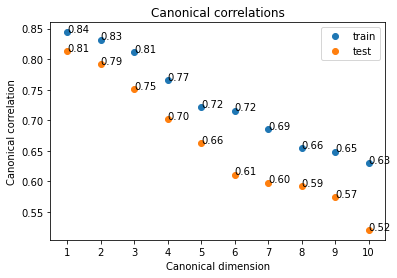

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_canonical_comps(train_comps, test_comps, spectra_type):
    """Plot all the CCA dimensions and the corresponding train and test correlation
    between data view 1 and data view 2.
    """
    sns.reset_orig()
    x = np.arange(latent_dims)+1
    # Plot canonical correlations (cca.cancorrs)
    plt.plot(x, train_comps, 'o')
    plt.plot(x, test_comps, 'o')
    plt.xlim(0.5, 0.5+latent_dims)
    plt.xticks(x)
    plt.xlabel('Canonical dimension')
    plt.ylabel('Canonical correlation')
    plt.title('Canonical correlations')# %s - %s' % (method, spectra_type))
    plt.legend(labels=['train', 'test'])

    # disabled for now cause slowish
    for i, txt in enumerate(train_comps):
        plt.annotate("{:.2f}".format(txt), (x[i], train_comps[i]))
    for i, txt in enumerate(test_comps):
        plt.annotate("{:.2f}".format(txt), (x[i], test_comps[i]))
        
plot_canonical_comps(*comps, spectra_type)

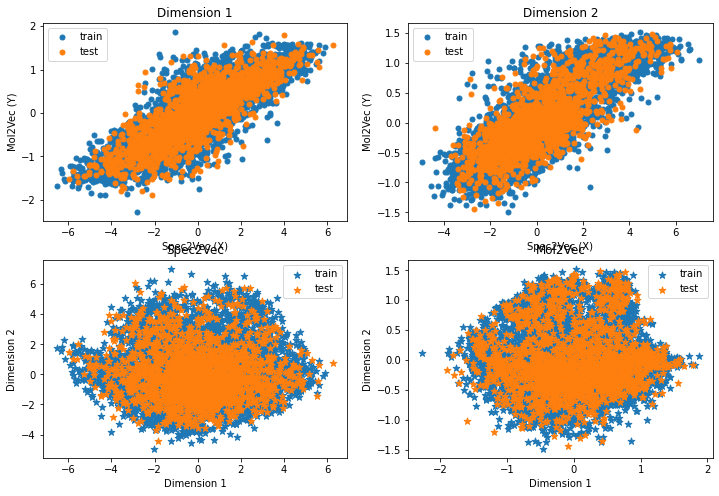

In [19]:
def plot_latent_space(trainX_latent, testX_latent, trainY_latent, testY_latent, spectra_type):
    """
    """
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.scatter(trainX_latent[:, 0], trainY_latent[:, 0], label="train",
                marker="o", s=25)
    plt.scatter(testX_latent[:, 0], testY_latent[:, 0], label="test",
                marker="o", s=25)
    plt.xlabel("Spec2Vec (X)")
    plt.ylabel("Mol2Vec (Y)")
    plt.title('Dimension 1')
    plt.legend(loc="best")

    plt.subplot(222)
    plt.scatter(trainX_latent[:, 1], trainY_latent[:, 1], label="train",
                marker="o", s=25)
    plt.scatter(testX_latent[:, 1], testY_latent[:, 1], label="test",
                marker="o", s=25)
    plt.xlabel("Spec2Vec (X)")
    plt.ylabel("Mol2Vec (Y)")
    plt.title('Dimension 2')
    plt.legend(loc="best")

    plt.subplot(223)
    plt.scatter(trainX_latent[:, 0], trainX_latent[:, 1], label="train",
                marker="*", s=50)
    plt.scatter(testX_latent[:, 0], testX_latent[:, 1], label="test",
                marker="*", s=50)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title('Spec2Vec')
    plt.legend(loc="best")

    plt.subplot(224)
    plt.scatter(trainY_latent[:, 0], trainY_latent[:, 1], label="train",
                marker="*", s=50)
    plt.scatter(testY_latent[:, 0], testY_latent[:, 1], label="test",
                marker="*", s=50)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title('Mol2Vec')
    plt.legend(loc="best")
    
    plt.show()
    
plot_latent_space(*latent, spectra_type)

## 3. Cross-modal retrieval
Here, the latent space will be utilized to do cross-modal retrieval using cosine similarity as a distance measure. In the ideal world, you would query a spectra, and then retrieve the structure that belongs to that spectra, but that is not always possible. Especially when using test data, for which the structures don't exist in the latent space, as the model is trained on the train data.

In [20]:
import heapq
from scipy.spatial import distance

def get_tanimoto(q_inchi, match_df):
    """Get all tanimoto similarities for a given query and list of targets."""
    tanimoto_list = []
    for i, match in match_df.iterrows():
        m_inchi = match.inchikey14  # Get inchikey of match
        tanimoto = tanimoto_matrix[q_inchi][m_inchi]  # Get tanimoto similarity from the matrix
        tanimoto_list.append(tanimoto)
    return tanimoto_list

def get_all_tanimoto(df_query, df_library, nn=1, metric='cosine'):
    """For each query, get n nearest neighbours and all tanimoto scores 
    for each nearest neighbour. DFs are either df_train, df_test or df (both combined).
    """
    # Make distance matrix between X and Y
    cdist_matrix = distance.cdist([x for x in df_query['X']],
                                  [x for x in df_library['Y']],
                                  metric=metric)
    
    # loop through each row in the dist matrix
    all_match_tanimoto_list = []
    all_rand_tanimoto_list = []
    for i, dist_list in enumerate(tqdm(cdist_matrix)): 
        # Get query info
        query = df_query.iloc[[i]]  # iloc looks by row number; 0, 1, 2...
        q_inchi = query.inchikey14.values[0]  # Get inchikey of query
        
        # Get n amount of smallest distances, e.g. 100
        smallest_dists_list = heapq.nsmallest(nn, dist_list)
        
        # Find rows that match the smallest dists 
        match_df = df_library[np.isin(dist_list, smallest_dists_list)]
        
        # Loop matches and get tanimoto similarity with query
        match_tanimoto_list = get_tanimoto(q_inchi, match_df)
        rand_tanimoto_list = get_tanimoto(q_inchi, df_library.sample(nn))
        
        all_match_tanimoto_list.append(match_tanimoto_list)
        all_rand_tanimoto_list.append(rand_tanimoto_list)
    return all_match_tanimoto_list, all_rand_tanimoto_list

def get_max_tanimoto(tanimoto_list, nn_list):
    """From list of e.g. 100 nn results, cut off list at certain points for plotting
    and then take the max tanimoto of those nearest neighbours.
    """
    max_tanimoto_dict = {}
    for nn in nn_list:  # Loop through nns
        max_tanimoto_list = []
        for all_tanimoto in tanimoto_list:  # Loop through matches
            curr_tanimoto = all_tanimoto[:nn]  # Cut off at certain spots
            max_tanimoto = max(curr_tanimoto)  # Get max over all nearest neighbours
            max_tanimoto_list.append(max_tanimoto)
        max_tanimoto_dict[nn] = max_tanimoto_list
    return max_tanimoto_dict

def get_tanimoto_dataframe(df_query, df_library, nn_list, metric, test=False):
    """Perform all steps to get matches, get tanimoto similarity for each match, and 
    get max tanimoto similarity for each group of nearest neighbours.
    -------------------------
    nn_list: list of n nearest neighbours in inverse order
    metric: cosine, euclidean
    test: True or False"""
    
    # Find matches and get all n tanimoto scores query-match
    match_tanimoto_list, rand_tanimoto_list = get_all_tanimoto(df_query, df_library, nn=max(nn_list), metric=metric)

    # Get max tanimoto score for all nns
    match_tanimoto_dict = get_max_tanimoto(match_tanimoto_list, nn_list)
    rand_tanimoto_dict = get_max_tanimoto(rand_tanimoto_list, nn_list)

    # Turn into dataframes
    match_df = pd.DataFrame(match_tanimoto_dict)
    match_df['random'] = False
    
    rand_df = pd.DataFrame(rand_tanimoto_dict)
    rand_df['random'] = True
    
    # Combine 'real' matches and 'random' matches
    comb_df = pd.concat([match_df, rand_df])
    comb_df['test'] = test  # Add column to indicate if train or test data
        
    return comb_df

In [21]:
# Prediction settings
nn_list = [100, 50, 10, 5, 1]
metric = 'cosine'

# Perform all the steps for both train and test
train_tanimoto_df = get_tanimoto_dataframe(df_train, df_train, nn_list, metric)
test_tanimoto_df = get_tanimoto_dataframe(df_test, df_train, nn_list, metric, test=True)

  0%|          | 0/7293 [00:00<?, ?it/s]

  0%|          | 0/1824 [00:00<?, ?it/s]

In [22]:
# Combine train and test and melt to suitable format for sns.FacetGrid()
tanimoto_df = pd.concat([train_tanimoto_df, test_tanimoto_df])
tanimoto_df_m = tanimoto_df.melt(id_vars=['test','random'], var_name='nn', value_name='tanimoto')

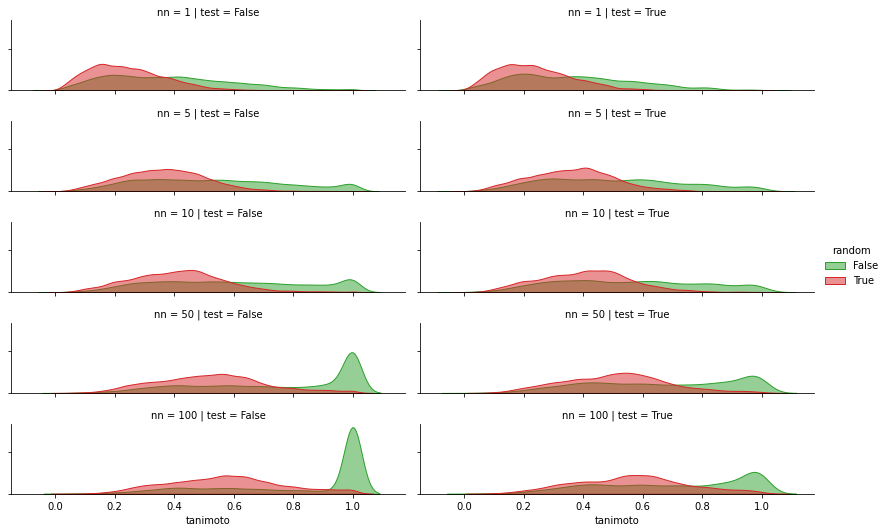

In [23]:
# Make distribution plots
g = sns.FacetGrid(tanimoto_df_m, 
                  row='nn', col='test', hue='random',
                  aspect=4, height=1.5, palette=["C2", "C3"])
g.map(sns.kdeplot, 'tanimoto', bw_adjust=0.7, shade=True, alpha=0.5)
g.set(ylabel=None, yticklabels=[])
g.add_legend()

The plot above shows that the 'real' distribution, the green one, does *much* better than the random distribution, especially for the higher nearest neighbours. This is also shown in the boxplots below.

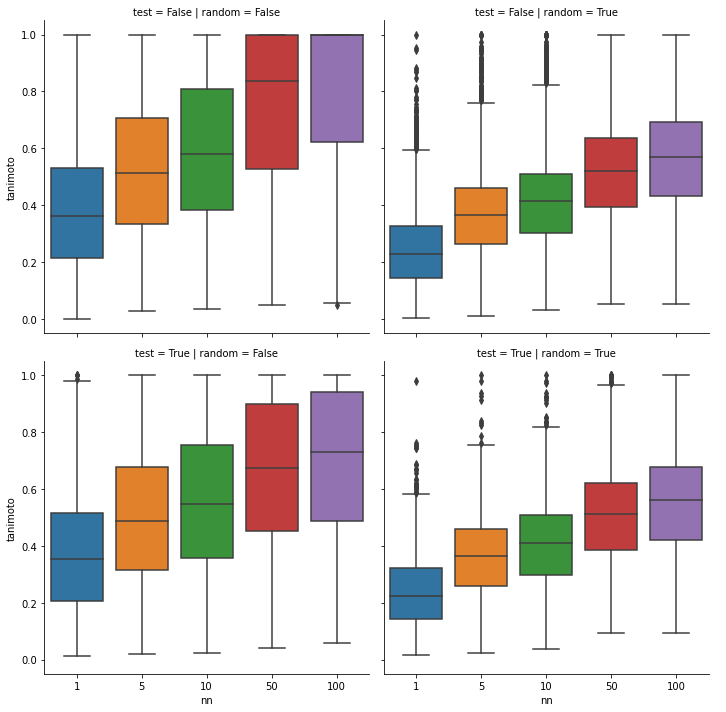

In [24]:
# Make boxplot of the same data
g = sns.catplot(
    data=tanimoto_df_m, x='nn', y='tanimoto',
    col='random', row='test', kind='box'
)
g.add_legend()